## Predictive models for NFL games to enable spread betting.

### Load packages and data files

In [58]:
# basic python packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, accuracy_score,  r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

In [59]:
# regression model packages
import xgboost as xgb
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

In [60]:
#import data
df_results = pd.read_csv('../data/nfl_games_pfr.csv')
print(df_results.columns)

Index(['Unnamed: 0', 'Week', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome',
       'Loser', 'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Winner Yds',
       'Loser Yds', 'Margin Yds', 'Winner TO', 'Loser TO', 'Margin TO',
       'Margin Pts', 'Total Pts', 'Margin Pct', 'home_team_winner',
       'away_win_bonus', 'DateTime', 'DaysSinceLastGame_Home',
       'DaysSinceLastGame_Away'],
      dtype='object')


### Create rankings using pagerank from nx

In [61]:
# Graph Functions
def create_graph(game_data, week_num):
    G = nx.DiGraph()
    margin_totals = defaultdict(float)
    game_counts = defaultdict(int)
    
    # Iterate over each game result
    for _, row in game_data.iterrows():
        winner = row['winner']
        loser = row['loser']
        week = row['week']
        margin = row['margin']

        key = (loser, winner)
        margin_totals[key] += margin
        game_counts[key] += 1

    # Add edges with average margin as weight
    for (loser, winner), total_margin in margin_totals.items():
        avg_margin = total_margin / game_counts[(loser, winner)]
        G.add_edge(loser, winner, weight=avg_margin)
    
    return G

# Function to calculate rankings based on the weighted graph
def calculate_rankings(graph):
    # Calculate PageRank with weights
    return pd.DataFrame(nx.pagerank(graph, alpha=0.95, weight='weight').items(), columns=['Team', 'Ranking'])

# Function to generate rankings for each season and week
def generate_rankings(df_filtered, feature_type):
    # Initialize an empty list to store rankings DataFrames
    ranking_dfs = []

    # Loop over each distinct season in the dataset
    for season in df_filtered['season'].unique():
        # Filter the game data for the current season
        season_data = df_filtered[df_filtered['season'] == season]
        
        # Loop over the weeks for this season
        for week in range(2, season_data['week'].max() + 1):
            # Filter the game data up to the current week for the current season
            filtered_data = season_data[season_data['week'] <= week]
            
            # Create the directed graph for the current season and weeks
            G = create_graph(filtered_data, week)
            
            # Calculate the rankings based on the weighted graph
            rankings = calculate_rankings(G)

            # Round the rankings to 4 decimal places
            rankings['Ranking'] = rankings['Ranking'].round(5)
            
            # Add columns indicating the season and week, with a leading zero for weeks
            rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
            rankings['Season'] = season
            rankings['Week'] = week
            rankings['Type'] = feature_type
            
            # Append the rankings to the list
            ranking_dfs.append(rankings)
    
    # Concatenate all rankings DataFrames into a single DataFrame
    return pd.concat(ranking_dfs)

print("DONE")

DONE


In [62]:
# Function to calculate the Strength of Schedule (SoS)
def calculate_strength_of_schedule(graph, pagerank):
    sos = defaultdict(float)
    for team in graph.nodes:
        opponents = list(graph.predecessors(team)) + list(graph.successors(team))
        if opponents:
            sos[team] = sum(pagerank.get(opponent, 0) for opponent in opponents) / len(opponents)
        else:
            sos[team] = 0
    return sos

# Function to generate rankings for each season and week with SoS and iteration
def generate_rankings_with_sos(df_filtered, feature_type, iterations=20):
    # Initialize an empty list to store rankings DataFrames
    ranking_dfs = []

    # Loop over each distinct season in the dataset
    for season in df_filtered['season'].unique():
        # Filter the game data for the current season
        season_data = df_filtered[df_filtered['season'] == season]

        # Loop over the weeks for this season
        for week in range(2, season_data['week'].max() + 1):
            # Filter the game data up to the current week for the current season
            filtered_data = season_data[season_data['week'] <= week]
            
            # Create the directed graph for the current season and weeks
            G = create_graph(filtered_data, week)
            
            # Initial PageRank calculation
            pagerank = dict(nx.pagerank(G, alpha=0.9, weight='weight'))

            # Iteratively refine the rankings with SoS
            for _ in range(iterations):
                sos = calculate_strength_of_schedule(G, pagerank)
                
                # Adjust rankings based on strength of schedule
                adjusted_pagerank = {}
                for team, rank in pagerank.items():
                    adjusted_pagerank[team] = rank * (1 + sos[team])  # Adjust by SoS
                
                # Normalize adjusted PageRank
                total_rank = sum(adjusted_pagerank.values())
                pagerank = {team: rank / total_rank for team, rank in adjusted_pagerank.items()}

            # Convert pagerank dict to DataFrame
            rankings = pd.DataFrame(pagerank.items(), columns=['Team', 'Ranking'])

            # Round the rankings to 5 decimal places
            rankings['Ranking'] = rankings['Ranking'].round(5)
            
            # Add columns indicating the season and week, with a leading zero for weeks
            rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
            rankings['Season'] = season
            rankings['Week'] = week
            rankings['Type'] = feature_type
            
            # Append the rankings to the list
            ranking_dfs.append(rankings)
    
    # Concatenate all rankings DataFrames into a single DataFrame
    return pd.concat(ranking_dfs)

In [63]:
### OFFENSE ###
# Filtered data frames for each feature set
df_offense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Yds','Loser Yds','Margin Yds']]
df_offense = df_offense.rename(columns={'Winner Yds':'winner', 'Loser Yds':'loser','Margin Yds':'margin'})

# Generate rankings for each feature type
#final_offense_rankings_df = generate_rankings(df_offense, "Offense")
final_offense_rankings_df = generate_rankings_with_sos(df_offense, "Offense")
print(final_offense_rankings_df.head())
print(len(final_offense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0   KC  0.00811   2024_W02    2024     2  Offense
1  BAL  0.01679   2024_W02    2024     2  Offense
2  PHI  0.00774   2024_W02    2024     2  Offense
3   GB  0.00960   2024_W02    2024     2  Offense
4  ATL  0.01486   2024_W02    2024     2  Offense
4864


In [64]:
### DEFENSE ###
# Filtered data frames for each feature set
df_defense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner TO','Loser TO','Margin TO']]
df_defense = df_defense.rename(columns={'Winner TO':'winner', 'Loser TO':'loser','Margin TO':'margin'})

# Generate rankings for each feature type
#final_defense_rankings_df = generate_rankings(df_defense, "Defense")
final_defense_rankings_df = generate_rankings_with_sos(df_defense, "Defense")
print(final_defense_rankings_df.head())
print(len(final_defense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0  BAL  0.02866   2024_W02    2024     2  Defense
1   KC  0.04753   2024_W02    2024     2  Defense
2   GB  0.02164   2024_W02    2024     2  Defense
3  PHI  0.04544   2024_W02    2024     2  Defense
4  PIT  0.01889   2024_W02    2024     2  Defense
4864


In [65]:
### SCORE ###
# Filtered data frames for each feature set
df_score = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Abbr','Loser Abbr','Margin Pts']]
df_score = df_score.rename(columns={'Winner Abbr':'winner', 'Loser Abbr':'loser', 'Margin Pts':'margin'})

# Generate rankings for each feature type
#final_score_rankings_df = generate_rankings(df_score, "Score")
final_score_rankings_df = generate_rankings_with_sos(df_score, "Score")
print(final_score_rankings_df.head())
print(len(final_score_rankings_df))

  Team  Ranking SeasonWeek  Season  Week   Type
0  BAL  0.01280   2024_W02    2024     2  Score
1   KC  0.01972   2024_W02    2024     2  Score
2   GB  0.02534   2024_W02    2024     2  Score
3  PHI  0.05165   2024_W02    2024     2  Score
4  ATL  0.08729   2024_W02    2024     2  Score
4864


In [66]:
# Concatenate all feature rankings into a single DataFrame
final_rankings_df = pd.concat([final_offense_rankings_df, final_score_rankings_df, final_defense_rankings_df])
print(final_rankings_df.head())
print(len(final_rankings_df))
final_rankings_df.to_csv('../data/nfl_rankings_combined.csv')

  Team  Ranking SeasonWeek  Season  Week     Type
0   KC  0.00811   2024_W02    2024     2  Offense
1  BAL  0.01679   2024_W02    2024     2  Offense
2  PHI  0.00774   2024_W02    2024     2  Offense
3   GB  0.00960   2024_W02    2024     2  Offense
4  ATL  0.01486   2024_W02    2024     2  Offense
14592


#### Create additional features and interaction variables

In [67]:
# Preprocess the combined_rankings dataframe to create offensive and defensive rank features
rankings = final_rankings_df.pivot(index=['Team', 'SeasonWeek', 'Season', 'Week'], columns='Type', values='Ranking').reset_index()
rankings.rename(columns={'Offense': 'OffenseRank', 'Defense': 'DefenseRank', 'Score': 'ScoreRank'}, inplace=True)

# Adjust rankings to use the prior week's data
rankings['Week'] += 1

# Merge the rankings with game results to create the feature set
def merge_rankings(df, team_column, prefix):
    return df.merge(rankings, left_on=[team_column, 'season', 'week'], right_on=['Team', 'Season', 'Week'], how='left') \
             .rename(columns={'OffenseRank': f'{prefix}_OffenseRank',
                              'DefenseRank': f'{prefix}_DefenseRank',
                              'ScoreRank': f'{prefix}_ScoreRank'})

merged_df = merge_rankings(df_results, 'Home Team', 'Home')
merged_df = merge_rankings(merged_df, 'Away Team', 'Away')

# Drop unnecessary columns
merged_df.drop(columns=['Unnamed: 0', 'Team_x', 'Season_x', 'SeasonWeek_x', 'Week_x',
                        'Team_y', 'Season_y', 'SeasonWeek_y', 'Week_y'], inplace=True)

# Filter to only games where rankings exist for both teams
merged_df.dropna(subset=['Home_OffenseRank', 'Home_DefenseRank', 'Away_OffenseRank', 'Away_DefenseRank'], inplace=True)

# Create target variable (spread)
merged_df['Spread'] = merged_df.apply(lambda row: row['PtsW'] - row['PtsL']
                                      if row['Home Team'] == row['Winner Abbr']
                                      else row['PtsL'] - row['PtsW'], axis=1)

# Create feature deltas and ratios
rank_features = ['OffenseRank', 'DefenseRank', 'ScoreRank']
for feature in rank_features:
    merged_df[f'Delta_{feature}'] = merged_df[f'Home_{feature}'] - merged_df[f'Away_{feature}']
    merged_df[f'Ratio_{feature}'] = merged_df[f'Home_{feature}'] / (merged_df[f'Away_{feature}'] + 1e-5)

# Create interaction and quadratic terms
interaction_terms = [
    ('Home_OffenseRank', 'Away_DefenseRank'),
    ('Away_OffenseRank', 'Home_DefenseRank'),
    ('Home_OffenseRank', 'Away_OffenseRank'),
    ('Away_DefenseRank', 'Home_DefenseRank')
]
for i, (col1, col2) in enumerate(interaction_terms, 1):
    merged_df[f'intTerm{i}'] = merged_df[col1] * merged_df[col2]

quadratic_terms = [
    'Home_OffenseRank', 'Away_OffenseRank', 'Home_DefenseRank', 'Away_DefenseRank'
]
for i, col in enumerate(quadratic_terms, 1):
    merged_df[f'quadTerm{i}'] = merged_df[col] ** 2

# Create strength features
merged_df['HomeStrength'] = merged_df['Home_OffenseRank'] + merged_df['Home_DefenseRank'] + merged_df['Home_ScoreRank']
merged_df['AwayStrength'] = merged_df['Away_OffenseRank'] + merged_df['Away_DefenseRank'] + merged_df['Away_ScoreRank']

# Create variable for historical and future games
merged_df['GameType'] = merged_df.apply(lambda row: "Historical" 
                                      if not pd.isna(row['Margin Yds'])
                                      else "Future", axis=1)

print(merged_df.columns)
merged_df.to_csv('../data/nfl_games_pfr_features.csv')

#Separate played and upcoming games
merged_played = merged_df[~merged_df['Margin Yds'].isna()]
merged_upcoming = merged_df[merged_df['Margin Yds'].isna()]
print(len(merged_played),len(merged_upcoming))

Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Winner Yds', 'Loser Yds',
       'Margin Yds', 'Winner TO', 'Loser TO', 'Margin TO', 'Margin Pts',
       'Total Pts', 'Margin Pct', 'home_team_winner', 'away_win_bonus',
       'DateTime', 'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away',
       'Home_DefenseRank', 'Home_OffenseRank', 'Home_ScoreRank', 'Week',
       'Away_DefenseRank', 'Away_OffenseRank', 'Away_ScoreRank', 'Spread',
       'Delta_OffenseRank', 'Ratio_OffenseRank', 'Delta_DefenseRank',
       'Ratio_DefenseRank', 'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1',
       'intTerm2', 'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2',
       'quadTerm3', 'quadTerm4', 'HomeStrength', 'AwayStrength', 'GameType'],
      dtype='object')
2124 15


## Model and basic feature evaluation

In [68]:
# Function to train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

scaler = StandardScaler()

In [69]:
# Define features and target

filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.02]

feature_sets = [
    filtered_played[['Home_ScoreRank','Away_ScoreRank']], 
    filtered_played[['Delta_ScoreRank']],
    filtered_played[['Ratio_ScoreRank']],
    filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank', 'Away_DefenseRank','Away_ScoreRank']],
    filtered_played[['Delta_ScoreRank','Delta_OffenseRank','Delta_DefenseRank']],
    filtered_played[['Ratio_ScoreRank','Ratio_OffenseRank','Ratio_DefenseRank']],
    filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Away_OffenseRank', 'Away_DefenseRank']],
    filtered_played[['Delta_OffenseRank','Delta_DefenseRank']],
    filtered_played[['Ratio_OffenseRank','Ratio_DefenseRank']],
    filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank',\
               'Away_DefenseRank','Away_ScoreRank', 'Delta_ScoreRank','Delta_OffenseRank',\
                'Delta_DefenseRank', 'Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank',\
                'intTerm1', 'intTerm2','intTerm3', 'intTerm4', \
                'quadTerm1','quadTerm2', 'quadTerm3', 'quadTerm4', \
                'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', \
                'HomeStrength', 'AwayStrength']],
    pd.DataFrame(scaler.fit_transform(filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank',\
               'Away_DefenseRank','Away_ScoreRank', 'Delta_ScoreRank','Delta_OffenseRank',\
                'Delta_DefenseRank', 'Ratio_ScoreRank', 'Ratio_OffenseRank', 'Ratio_DefenseRank',\
                'intTerm1', 'intTerm2','intTerm3', 'intTerm4', \
                'quadTerm1','quadTerm2', 'quadTerm3', 'quadTerm4', \
                'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', \
                'HomeStrength', 'AwayStrength']]))

]

y = filtered_played['Spread']

# Define models
models = [
    ('LM', LinearRegression()),
    ('LMnoINT', LinearRegression(fit_intercept=False)),
    ('Ridge0.05', Ridge(alpha=0.05)),
    ('Ridge0.1', Ridge(alpha=0.1)),
    ('Ridge0.5', Ridge(alpha=0.5)),  # You can tune the alpha parameter
    ('XGBoostBase', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost150', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)),
    ('XGBoost0.5', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)),
    ('RF50', RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)),
    ('RF10', RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)),
    ('SVM', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ('SVMlin', SVR(kernel='linear', C=1.0, epsilon=0.1)),
    ('kNN5', KNeighborsRegressor(n_neighbors=5)),
    ('kNN17', KNeighborsRegressor(n_neighbors=17)),
    ('BaselineAvg', DummyRegressor(strategy='mean'))
]

print("DONE")

DONE


In [70]:
# DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over feature sets and models
for i, X in enumerate(feature_sets):
    for model_name, model in models:
        print(f"Evaluating model: {model_name} with feature set {i+1}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(X):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model = train_model(model, X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [model_name],
                'Feature_Set': [f'Set {i+1}'],
                'Fold': [fold_number],
                'MSE': [mse],
                'Accuracy': [accuracy * 100]
            })
            results = pd.concat([results, new_result], ignore_index=True)
            
            fold_number += 1

# Print the results DataFrame
#print(results)

Evaluating model: LM with feature set 1
Evaluating model: LMnoINT with feature set 1
Evaluating model: Ridge0.05 with feature set 1
Evaluating model: Ridge0.1 with feature set 1
Evaluating model: Ridge0.5 with feature set 1
Evaluating model: XGBoostBase with feature set 1


C:\Users\watersma\AppData\Local\Temp\ipykernel_31468\2101033413.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Evaluating model: XGBoost150 with feature set 1
Evaluating model: XGBoost5 with feature set 1
Evaluating model: XGBoost0.5 with feature set 1
Evaluating model: RF50 with feature set 1
Evaluating model: RF10 with feature set 1
Evaluating model: SVM with feature set 1
Evaluating model: SVMlin with feature set 1
Evaluating model: kNN5 with feature set 1
Evaluating model: kNN17 with feature set 1
Evaluating model: BaselineAvg with feature set 1
Evaluating model: LM with feature set 2
Evaluating model: LMnoINT with feature set 2
Evaluating model: Ridge0.05 with feature set 2
Evaluating model: Ridge0.1 with feature set 2
Evaluating model: Ridge0.5 with feature set 2
Evaluating model: XGBoostBase with feature set 2
Evaluating model: XGBoost150 with feature set 2
Evaluating model: XGBoost5 with feature set 2
Evaluating model: XGBoost0.5 with feature set 2
Evaluating model: RF50 with feature set 2
Evaluating model: RF10 with feature set 2
Evaluating model: SVM with feature set 2
Evaluating mode

In [ ]:
# Print the results DataFrame
print(results.to_csv(index=False))

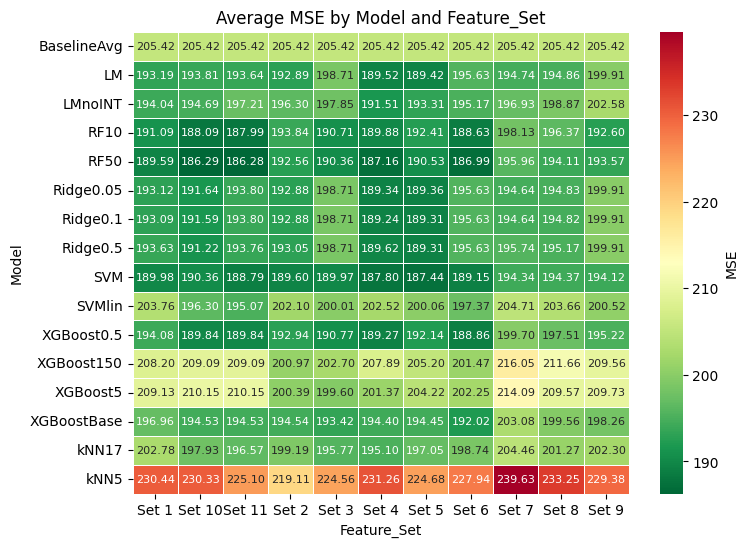

In [74]:
# Create crosstab with Model as rows, Feature_Set as columns, and mean of MSE
crosstab_df = pd.pivot_table(results, values='MSE', index='Model', columns='Feature_Set', aggfunc='mean')

# Plot heatmap with gradient color scale (red to yellow to green)
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_df, cmap='RdYlGn_r', annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'MSE'}, annot_kws={"size": 8})

# Add title to the heatmap
plt.title('Average MSE by Model and Feature_Set')

# Display the heatmap
plt.show()

## Optimize the best model and feature set

Models: Random Forest, SVM, XGBoost  


In [ ]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.02]
X = filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank',\
               'Away_DefenseRank','Away_ScoreRank', \
                'intTerm1', 'intTerm2','intTerm3', 'intTerm4', \
                'quadTerm1','quadTerm2', 'quadTerm3', 'quadTerm4', \
                'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', \
                'HomeStrength', 'AwayStrength']]
y = filtered_played['Spread']

#X = sm.add_constant(X)
    
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)


model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse}")

# Extract feature importance
importance = model.feature_importances_

# Create a DataFrame to rank the features
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top features
print(feature_importance_df)

# Initialize RFE with RandomForest as the estimator
rfe = RFE(estimator=model, n_features_to_select=10)  # Select top 10 features

# Fit RFE
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Identify the selected features
selected_features = X_train.columns[rfe.support_]
print(f'Selected features: {selected_features}')

# Retrain the model with just the top features
X_train_top = X_train[selected_features]
X_test_top = X_test[selected_features]

rf_model_top = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
rf_model_top.fit(X_train_top, y_train)

# Evaluate the model with the top features
y_pred_top = rf_model_top.predict(X_test_top)
mse_top = mean_squared_error(y_test, y_pred_top)
print(f'Mean Squared Error with top features: {mse_top}')



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define your Random Forest model
rf = RandomForestRegressor()

# Create the hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 250],
    'max_depth': [2, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10, 25],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2',4]
}

# Perform randomized search
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=25, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", rf_random.best_params_)
best_rf = rf_random.best_estimator_

y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the Support Vector Regressor
svr = SVR()

# Hyperparameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10, 50],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# Perform grid search
svr_grid = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
svr_grid.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", svr_grid.best_params_)

# Get the best estimator
best_svr = svr_grid.best_estimator_

y_pred = best_svr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


In [ ]:
# Define your XGBoost model
xgb_model = xgb.XGBRegressor()

# Create the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5]
}

# Perform randomized search
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                n_iter=25, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the model
xgb_random.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", xgb_random.best_params_)
best_xgb = xgb_random.best_estimator_

# Make predictions and evaluate the model
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


### Models

Best model parameters:  
RF: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3}
SVM: {'C': 100, 'degree': 2, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'linear'}
XGB: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}

In [ ]:
# Define features and target

filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.02]

X = filtered_played[['Home_OffenseRank', 'Home_DefenseRank','Home_ScoreRank', 'Away_OffenseRank',\
               'Away_DefenseRank','Away_ScoreRank', \
                'intTerm1', 'intTerm2','intTerm3', 'intTerm4', \
                'quadTerm1','quadTerm2', 'quadTerm3', 'quadTerm4', \
                'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', \
                'HomeStrength', 'AwayStrength']]

target_sets = [
    filtered_played['Spread'],
    filtered_played['Spread'].clip(-15,15),
    pd.Series(winsorize(filtered_played['Spread'], limits=[0.05, 0.05])),
    pd.Series(winsorize(filtered_played['Spread'], limits=[0.1, 0.1]))
]

# Define models
models = [
    ('LM', LinearRegression()),
    ('RF', RandomForestRegressor(n_estimators=50, max_depth=3, min_samples_split=2,min_samples_leaf=1,max_features='sqrt')),
    ('SVM', SVR(kernel='linear', C=100, epsilon=10, degree=2)),
    ('XGB', xgb.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, gamma=0.1, subsample=0.8, colsample_bytree=1.0, min_child_weight=1)),
    ('BaselineAvg', DummyRegressor(strategy='mean'))
]

print("DONE")

In [ ]:
# DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Feature_Set', 'Fold', 'MSE', 'Accuracy'])

# Define cross-validation strategy (5 folds in this case)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over feature sets and models
for i, y in enumerate(target_sets):
    for model_name, model in models:
        print(f"Evaluating model: {model_name} with target set {i+1}")
        
        fold_number = 1
        # Cross-validation loop
        for train_index, test_index in kf.split(y):
            # Use iloc to select rows by integer index
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Train the model
            model = train_model(model, X_train, y_train)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            
            # Calculate accuracy of predicting the winner
            y_pred_winner = ['Home' if pred > 0 else 'Away' for pred in y_pred]
            y_test_winner = ['Home' if actual > 0 else 'Away' for actual in y_test]
            accuracy = accuracy_score(y_test_winner, y_pred_winner)
            
            # Store the results for each fold
            new_result = pd.DataFrame({
                'Model': [model_name],
                'Feature_Set': [f'Set {i+1}'],
                'Fold': [fold_number],
                'MSE': [mse],
                'Accuracy': [accuracy * 100]
            })
            results = pd.concat([results, new_result], ignore_index=True)
            
            fold_number += 1

# Print the results DataFrame
#print(results)

In [ ]:
# Print the results DataFrame
print(results.to_csv(index=False))

### Make next weeks predictions

In [75]:
filtered_played = merged_played[merged_played['Delta_ScoreRank'].abs() > 0.02]

feature_columns = [
    'Home_OffenseRank', 'Home_DefenseRank', 'Home_ScoreRank', 'Away_OffenseRank',
    'Away_DefenseRank', 'Away_ScoreRank', 'intTerm1', 'intTerm2', 'intTerm3', 'intTerm4',
    'quadTerm1', 'quadTerm2', 'quadTerm3', 'quadTerm4', 'DaysSinceLastGame_Home',
    'DaysSinceLastGame_Away', 'HomeStrength', 'AwayStrength'
]

# Select features and target variable
X = filtered_played[feature_columns]
y = filtered_played['Spread']

# Define the model
model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, gamma=0.1, 
                            subsample=0.8, colsample_bytree=1.0, min_child_weight=1)

# Fit the model
model.fit(X, y)

# Prepare the data for upcoming games
X_new = merged_upcoming[feature_columns]

# Predict the spread for upcoming games
y_pred_new = model.predict(X_new)

# Assign predictions to the merged_upcoming DataFrame (using .loc to avoid SettingWithCopyWarning)
merged_upcoming = merged_upcoming.assign(Predicted_Spread=y_pred_new)

# Print the selected columns
print(merged_upcoming[['Week','Home Team', 'Away Team', 'Delta_ScoreRank', 'Predicted_Spread']])

    Week Home Team Away Team  Delta_ScoreRank  Predicted_Spread
28   7.0        NO       DEN         -0.06851         -0.241318
29   7.0       JAC        NE          0.00589          3.125389
30   7.0       CLE       CIN         -0.00210         -3.470864
31   7.0       MIN       DET          0.00282         -0.091366
32   7.0        GB       HOU          0.01153          7.082263
33   7.0       IND       MIA          0.03689          4.962178
34   7.0       BUF       TEN          0.00767          3.332000
35   7.0       NYG       PHI         -0.02697          1.680107
36   7.0       ATL       SEA          0.01640          0.636672
37   7.0       WAS       CAR          0.01048          3.836346
38   7.0       LAR        LV         -0.00695          3.686340
39   7.0        SF        KC         -0.03298          3.824525
40   7.0       PIT       NYJ          0.07706          4.269361
41   7.0        TB       BAL          0.08659          4.918885
42   7.0       ARI       LAC         -0.

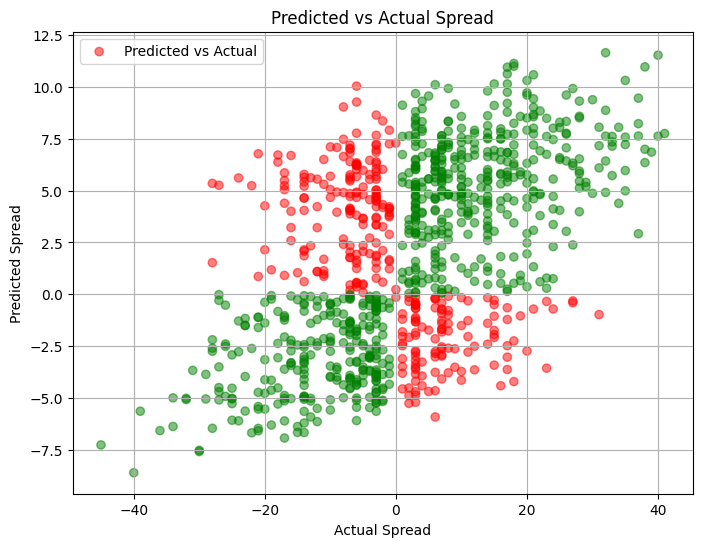

In [73]:
y_pred_fit = model.predict(X)


colors = np.where((y > 0) & (y_pred_fit > 0) | (y < 0) & (y_pred_fit < 0), 'green', 'red')

# Assuming y_pred_fit is already predicted and y contains actual values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_fit, alpha=0.5, c=colors, label='Predicted vs Actual')
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.title('Predicted vs Actual Spread')
plt.legend()
plt.grid(True)
plt.show()
